# Model with a simplified sigmoid scale

[Index](../0-index.ipynb)

Here we investigate whether a model with a sigmoid scale $p \beta$ is a good approximation of the pandemics spreading.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import os,sys
import numpy as np
import pandas as pd
import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('../..') / 'code'))

In [4]:
resdir = Path('../../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 835 entries.


## Global variables and other quantities

### Global variables

In [6]:
gamma = 1/10.
ti = '2020-03-01'
tf = '2021-02-16'

tfmt = '%Y-%m-%d'
ti = datetime.datetime.strptime(ti, tfmt)
tf = datetime.datetime.strptime(tf, tfmt)

pathtofit = Path('/fit')
pathtosimu = Path('/simulations/simplified')

exts = ['.png', '.svg']

### Load clusters to get population

In [7]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [8]:
population = clusters['population'].to_numpy()
population_inv = np.zeros(population.shape, dtype=np.float_)
idx = population > 0.
population_inv[idx] = 1./population[idx]

### Load CSSEGI data

In [9]:
path = '/clustering/cssegi'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    df_cssegi = store[path]

times = df_cssegi.index
idx = (times >= ti) & (times <= tf)
df_cssegi.drop(index=times[~idx], inplace=True)
times = df_cssegi.index.to_pydatetime().tolist()
df_cssegi

index,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
2020-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12,0,0,0,0,0,0,0,0,1215,239,...,0,0,397,0,181,21712,0,2540,2239,0
2021-02-13,0,0,0,0,0,0,0,0,1221,241,...,0,0,397,0,181,21758,0,2549,2241,0
2021-02-14,0,0,0,0,0,0,0,0,1227,241,...,0,0,397,0,181,21794,0,2553,2244,0
2021-02-15,0,0,0,0,0,0,0,0,1231,241,...,0,0,397,0,181,21817,0,2561,2244,0


In [10]:
omega_real = df_cssegi.to_numpy().astype('float64')
domega_real = np.diff(omega_real, axis=0)
domega_real = np.concatenate([omega_real[0].reshape(1,-1), domega_real], axis=0)

In [11]:
# compute the real epidemic sizes per community through time
T_real = np.einsum('ta,a->ta', omega_real, population_inv)
dT_real = np.einsum('ta,a->ta', domega_real, population_inv)
T_tot_real = np.einsum('ta,a->t', T_real, population) / np.sum(population)
dT_tot_real = np.einsum('ta,a->t', dT_real, population) / np.sum(population)

### Read fit

In [12]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(pathtofit / 'result' / 'fit')
    df_fit = store[mykey]

times = df_fit.index
idx = (times >= ti) & (times <= tf)
df_fit.drop(index=times[~idx], inplace=True)
times = df_fit.index.to_pydatetime().tolist()
df_fit

,scale,frac_infected_tot,scale_sigmoid,scale_step
2020-03-01,0.34322,0.0,0.251068,0.253942
2020-03-02,0.207449,0.0,0.250534,0.253942
2020-03-03,0.253454,0.0,0.249903,0.253942
2020-03-04,0.374544,0.0,0.249158,0.253942
2020-03-05,0.177103,0.000001,0.24828,0.253942
...,...,...,...,...
2021-02-12,0.040918,0.083887,0.055336,0.055336
2021-02-13,0.03206,0.084156,0.055336,0.055336
2021-02-14,0.027507,0.08436,0.055336,0.055336
2021-02-15,0.033736,0.084526,0.055336,0.055336


### Determine lockdown time

In [13]:
b_scales = df_fit['scale_step'].fillna(value=np.nan).to_numpy()
ic = np.nanargmax(np.abs(np.diff(b_scales))) + 1
tc = df_fit.index[ic]
print(f"lockdown at t = {tc}")

lockdown at t = 2020-03-25 00:00:00


In [14]:
df_fit.iloc[ic-1:ic+2]

,scale,frac_infected_tot,scale_sigmoid,scale_step
2020-03-24,0.140192,0.000172,0.166496,0.253942
2020-03-25,0.162633,0.000208,0.157958,0.055336
2020-03-26,0.150148,0.000259,0.14937,0.055336


## Perform simulation

### Construct the localization matrices

In [15]:
pathtoloc = pathtosimu / 'infectivity_matrices'

In [16]:
times = df_fit.index

In [17]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = pathtofit / 'infectivity_matrices' / times[0].strftime(tfmt)
    key = str(key)
    df_loc = store[key]

with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    t = times[0]
    pref = t.strftime(tfmt)

    key = pathtoloc / pref
    key = str(key)
    store[key] = df_loc

### Set initial condition

In [18]:
from functions import sir_SI_to_X

In [19]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(pathtofit / 'result' / 'susceptible')
    df_S_fit = store[mykey]
    
    mykey = str(pathtofit / 'result' / 'infected')
    df_I_fit = store[mykey]

In [20]:
Si = df_S_fit.iloc[0]
Ii = df_I_fit.iloc[0]
Xi = sir_SI_to_X(Si, Ii)

In [21]:
T_fit = 1. - df_S_fit.to_numpy().astype('float64')
dT_fit = np.diff(T_fit, axis=0)
dT_fit = np.concatenate([T_fit[0].reshape(1,-1), dT_fit], axis=0)

df_T_fit = pd.DataFrame(data=T_fit, index=df_S_fit.index, columns=df_S_fit.columns)
df_dT_fit = pd.DataFrame(data=dT_fit, index=df_S_fit.index, columns=df_S_fit.columns)

In [22]:
T_tot_fit = np.einsum('ta,a', T_fit, population) / np.sum(population)
dT_tot_fit = np.einsum('ta,a', dT_fit, population) / np.sum(population)

### Simulation

In [23]:
from functions import integrate_sir, get_sir_omega_SI

In [24]:
scales = df_fit.loc[:times[-1]-datetime.timedelta(days=1), 'scale_sigmoid'].to_numpy()
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    ts, Ss, Is  = integrate_sir(Xi, times, scales, gamma, store, pathtoloc)

df_S = pd.DataFrame(data=Ss, index=ts, columns=clusters.index)
df_I = pd.DataFrame(data=Is, index=ts, columns=clusters.index)

path = pathtosimu / 'result'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = path / 'susceptible'
    store[str(key)] = df_S
    
    key = path / 'infected'
    store[str(key)] = df_I

Integrating day 2020-03-01 00:00:00
Integrating day 2020-03-02 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-03 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-04 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-05 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-06 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-07 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-08 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-09 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-10 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-11 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-12 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-13 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-14 00:00:00
Infectivity matrix not updated!
Integrating day 2020-03-15 00:00:00
Infectivity matrix not updated!
Integrating 

In [25]:
path = pathtosimu / 'result'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = path / 'susceptible'
    df_S = store[str(key)]
    
    key = path / 'infected'
    df_I = store[str(key)]
    
    ts = df_S.index

In [26]:
S = df_S.to_numpy().astype('float64')
T = (1. - S)
dT = np.diff(T, axis=0)
dT = np.concatenate([T[0].reshape(1,-1), dT], axis=0)

df_T = pd.DataFrame(data=T, index=df_S.index, columns=df_S.columns)
df_dT = pd.DataFrame(data=dT, index=df_S.index, columns=df_S.columns)

In [27]:
T_tot = np.einsum('ta,a', T, population) / np.sum(population)
dT_tot = np.einsum('ta,a', dT, population) / np.sum(population)

### Plot epidemic size evolution

In [28]:
figdir = Path('..') / '..' / 'figures' / '6-simulations' / '61-simplified_model'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

In [29]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1
show_dT=True
Z = np.sum(population) / 1000


fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

if show_dT:
    ax.plot(times,dT_tot_fit*Z, '-', ms=ms, color='darkblue')
    ax.plot(times,dT_tot*Z, '-', ms=ms, color='darkgreen')
    ax.plot(times,dT_tot_real*Z, 'o', lw=lw, color='red')
    ax.set_ylabel("$d T$", fontsize="medium")
    fname = 'domega_tot_fit'
else:
    ax.plot(times,T_tot_fit*Z, '-', ms=ms, color='darkblue')
    ax.plot(times,T_tot*Z, '-', ms=ms, color='darkgreen')
    ax.plot(times,T_tot_real*Z, 'o', lw=lw, color='red')
    ax.set_ylabel("$T$", fontsize="medium")
    ax.set_yscale('log')
    fname = 'omega_tot_fit'

ax.set_xlim(times[0],None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../../figures/6-simulations/61-simplified_model/domega_tot_fit.png
Written file: ../../figures/6-simulations/61-simplified_model/domega_tot_fit.svg


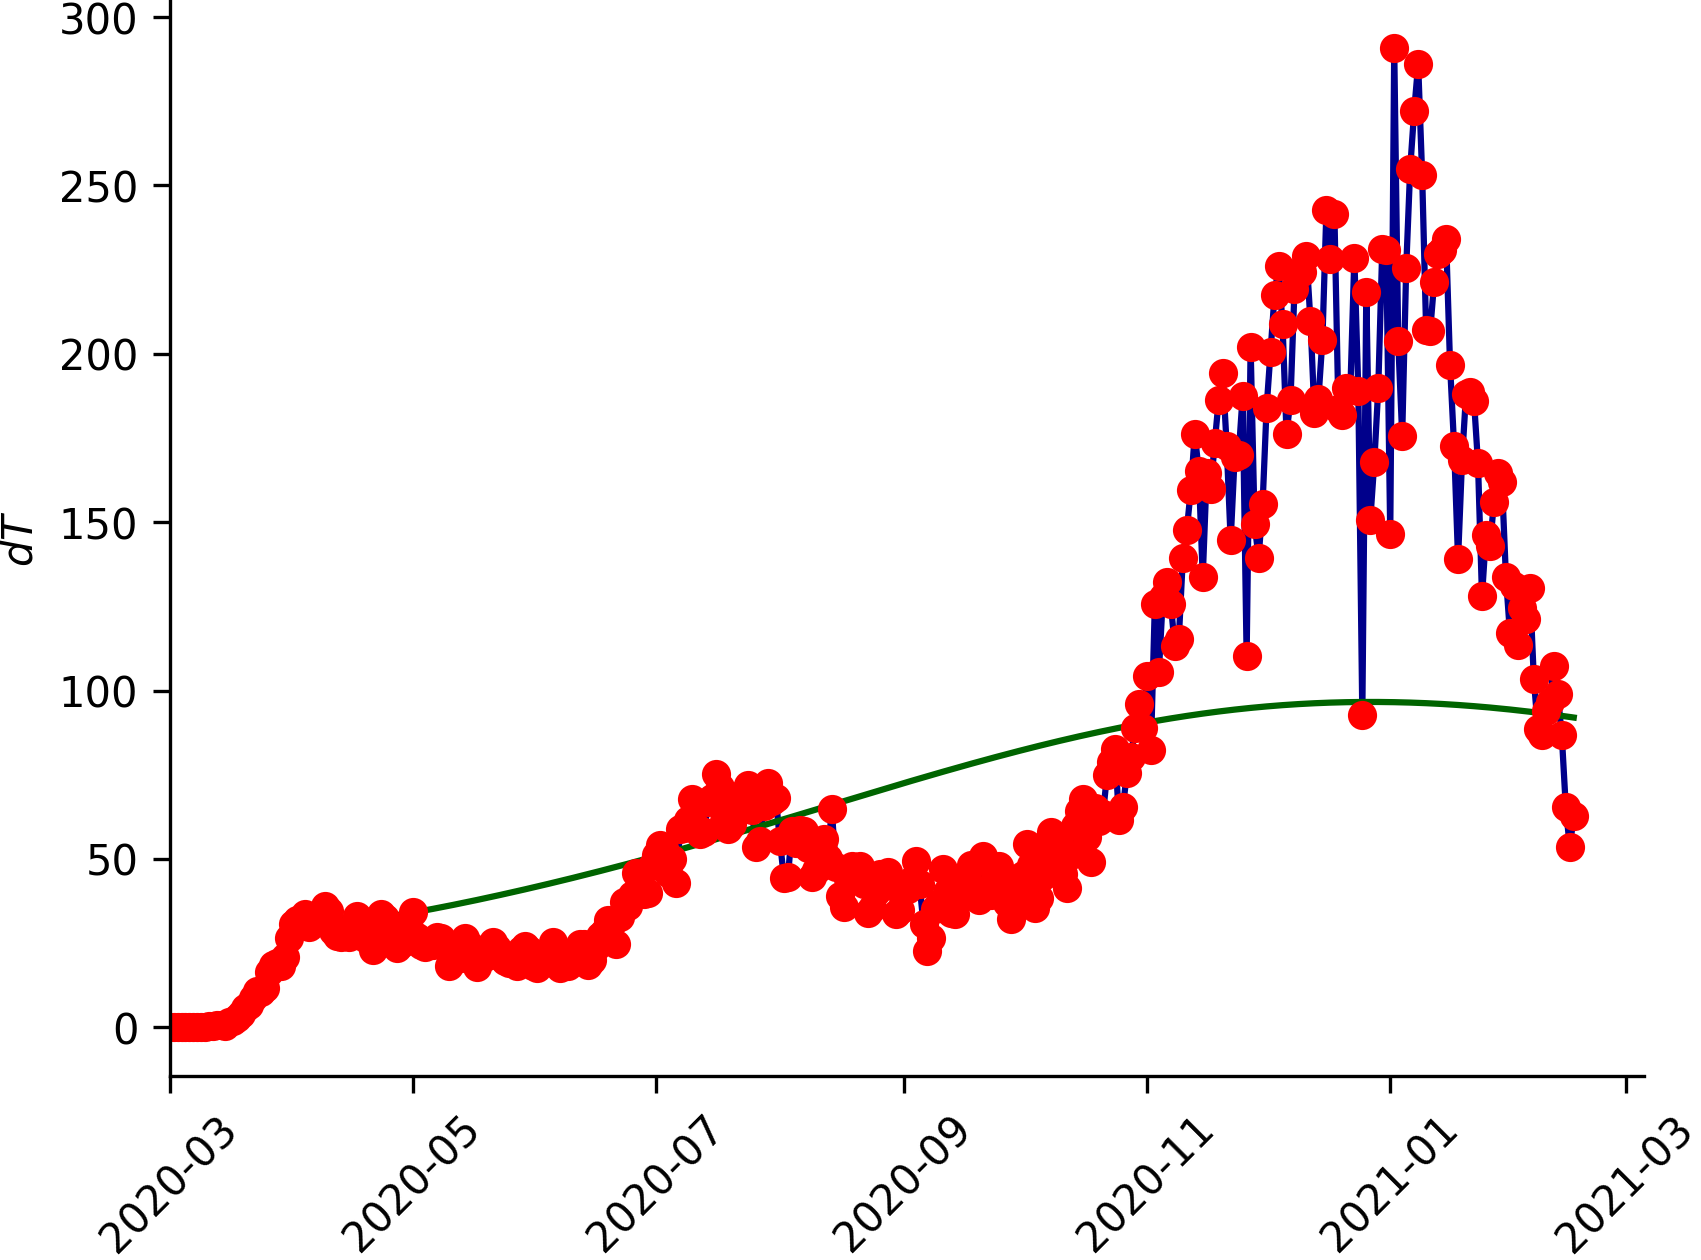

In [30]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Show spatial $T$ agreement

Show $T_a$

In [31]:
# parameters
vmin = 1.0e0
vmax = 1.0e6
cmap = cm.rainbow
figsize=(4,3)
dpi=300

## color mapping with date value
indices = np.arange(len(ts))
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
colors = cmap(norm(indices))

## make figure
fig = plt.figure(facecolor='w', figsize=figsize, dpi=dpi)
ax = fig.gca()

for i in range(len(ts)):
    t = ts[i]
    X = T_fit[i]*population
    Y = T[i]*population
    
    ax.plot(X, Y, 'o', color=colors[i], lw=0, mew=0, ms=2, alpha=0.1)    
ax.plot([vmin, vmax], [vmin, vmax], 'k-', lw=0.5)

# plot formatting
ax.set_xlabel("$T_a^\mathrm{fit}$", fontsize='medium')
ax.set_ylabel("$T_a$", fontsize='medium')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
ax.tick_params(length=4)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
    
fig.tight_layout(rect=[0.,0.,0.95,1.])
cax = fig.add_axes(rect=[0.99,0.2,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=cax, extendfrac='auto')
ticks = cbar.get_ticks()
labels = [ts[int(i)].strftime('%Y-%m-%d') for i in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

fname = 'T_model_vs_simplified'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../../figures/6-simulations/61-simplified_model/T_model_vs_simplified.png
Written file: ../../figures/6-simulations/61-simplified_model/T_model_vs_simplified.svg


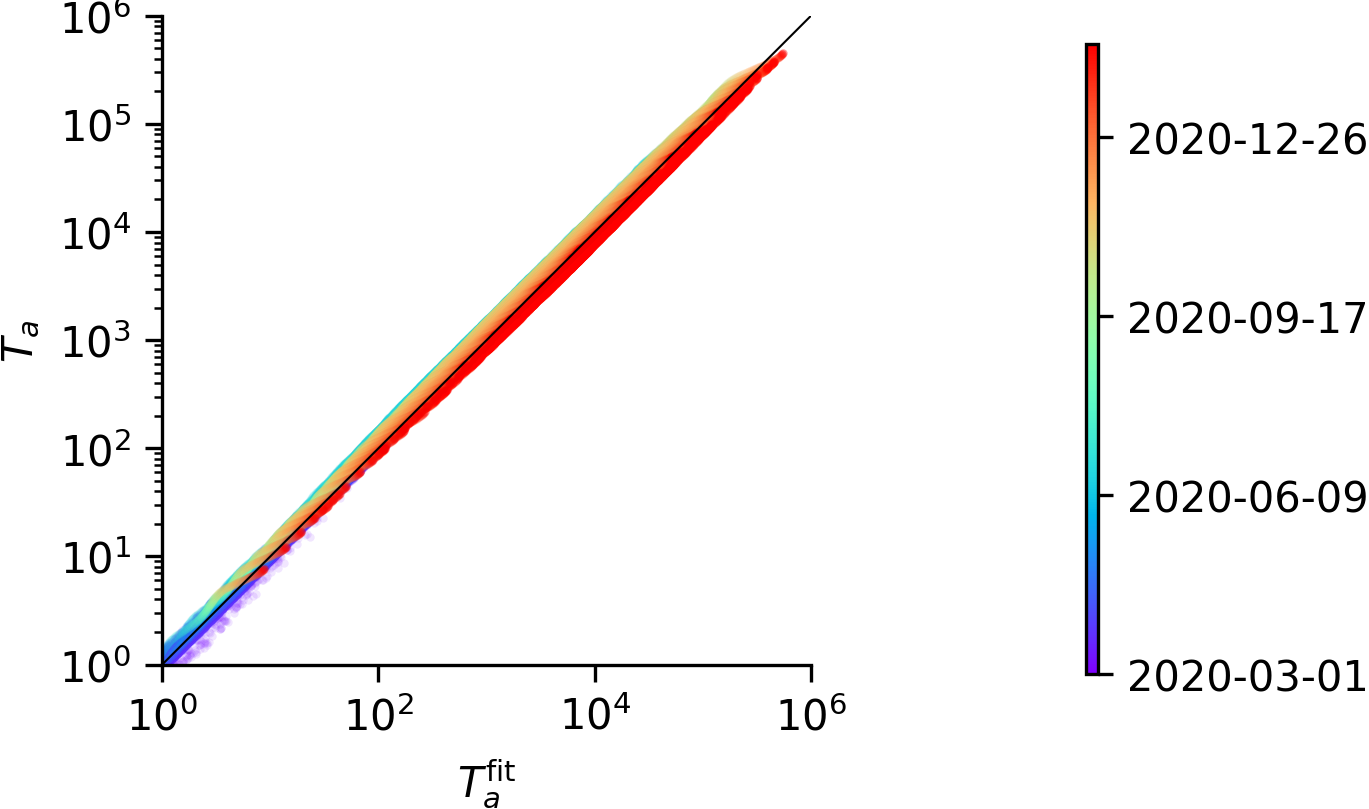

In [32]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

Show $dT_a$

In [33]:
# parameters
vmin = 1.0e0
vmax = 1.0e4
cmap = cm.rainbow
figsize=(4,3)
dpi=300

## color mapping with date value
indices = np.arange(len(ts))
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
colors = cmap(norm(indices))

## make figure
fig = plt.figure(facecolor='w', figsize=figsize, dpi=dpi)
ax = fig.gca()

for i in range(len(ts)):
    t = ts[i]
    X = dT_fit[i]*population
    Y = dT[i]*population
    
    ax.plot(X, Y, 'o', color=colors[i], lw=0, mew=0, ms=2, alpha=0.1)    

ax.plot([vmin, vmax], [vmin, vmax], 'k-', lw=0.5)
# plot formatting
ax.set_xlabel("$dT_a^\mathrm{fit}$", fontsize='medium')
ax.set_ylabel("$dT_a$", fontsize='medium')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
ax.tick_params(length=4)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
    
fig.tight_layout(rect=[0.,0.,0.95,1.])
cax = fig.add_axes(rect=[0.99,0.2,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=cax, extendfrac='auto')
ticks = cbar.get_ticks()
labels = [ts[int(i)].strftime('%Y-%m-%d') for i in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)


fname = 'dT_model_vs_simplified'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../../figures/6-simulations/61-simplified_model/dT_model_vs_simplified.png
Written file: ../../figures/6-simulations/61-simplified_model/dT_model_vs_simplified.svg


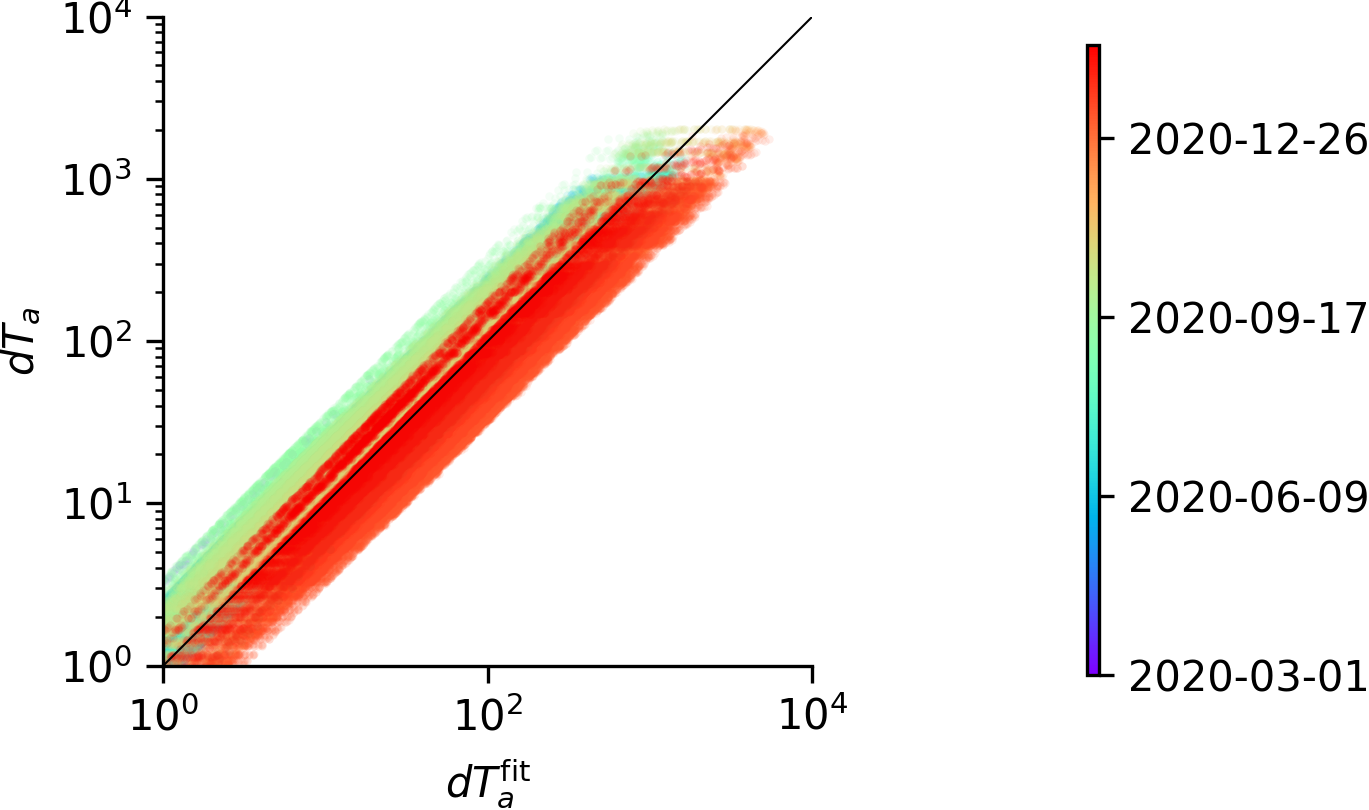

In [34]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Show time-dependent profile

In [35]:
from functions import plot_omega_profile

In [36]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4


mydir = figdir / 'profiles'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)

fpath = mydir / 'profile_T.mp4'
T_list = np.array([np.einsum('ta,a->ta', T_real[:,:],population), np.einsum('ta,a->ta', T_fit[:,:], population),  np.einsum('ta,a->ta', T[:,:], population)])
ylabel="$T_a$"
plot_omega_profile(T_list, times, labels=['real', 'fit', 'simplified'], colors=['red', 'darkblue', 'darkgreen'], \
                   fileout=fpath, tpdir=mydir / 'snapshots_T', dpi=dpi, fps=fps, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=['o', '-', '-'], deletetp=False, exts=['.png','.svg'], ymin=1.)

fpath = mydir / 'profile_dT.mp4'
T_list = np.array([np.einsum('ta,a->ta', dT_real[:,:],population), np.einsum('ta,a->ta', dT_fit[:,:], population),  np.einsum('ta,a->ta', dT[:,:], population)])
ylabel="$dT_a$"
plot_omega_profile(T_list, times, labels=['real', 'fit', 'simplified'], colors=['red', 'darkblue', 'darkgreen'], \
                   fileout=fpath, tpdir=mydir / 'snapshots_dT', dpi=dpi, fps=fps, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=['o', '-', '-'], deletetp=False, exts=['.png','.svg'], ymin=1.)

ymin = 1.00e+00 ymax = 1.00e+07
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-03-01.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-03-11.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-03-21.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-03-31.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-04-10.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-04-20.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-04-30.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-05-10.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020-05-20.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_T/2020

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (795, 605) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/61-simplified_model/profiles/profile_T.mp4.
ymin = 1.00e+00 ymax = 1.00e+05
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-03-01.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-03-11.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-03-21.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-03-31.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-04-10.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-04-20.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-04-30.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-05-10.png.
Written file ../../figures/6-simulations/61-simplified_model/profiles/snapshots_dT/2020-05-

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (796, 605) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/61-simplified_model/profiles/profile_dT.mp4.


In [37]:
fpath = figdir / 'profiles' / 'profile_T.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

In [38]:
fpath = figdir / 'profiles' / 'profile_dT.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

## Show time-dependent map

In [39]:
from functions import plot_omega_map

In [40]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4
idump=1

mydir = figdir / 'maps'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)


fpath = mydir / 'map_T.mp4'
plot_omega_map(np.einsum('ta,a->ta', T, population), times, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
fileout=fpath, tpdir=mydir / 'snapshots_T', dpi=dpi, fps=fps, figsize=figsize, idump=idump, \
               clabel="$T$", vmin=1., deletetp=False, exts=['.png','.svg'])
    
fpath = mydir / 'map_dT.mp4'
plot_omega_map(np.einsum('ta,a->ta', dT, population), times, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
fileout=fpath, tpdir=mydir / 'snapshots_dT', dpi=dpi, fps=fps, figsize=figsize, idump=idump, \
               clabel="$dT$", vmin=1., deletetp=False, exts=['.png','.svg'])

vmin = 1.00e+00 vmax = 1.00e+06
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-01.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-02.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-03.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-04.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-05.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-06.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-07.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-08.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-09.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_T/2020-03-10.png.
Written file ../../figures/6

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/61-simplified_model/maps/map_T.mp4.
vmin = 1.00e+00 vmax = 1.00e+04
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-01.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-02.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-03.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-04.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-05.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-06.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-07.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-08.png.
Written file ../../figures/6-simulations/61-simplified_model/maps/snapshots_dT/2020-03-09.png.
Written file ../../figures/6-simulat

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/61-simplified_model/maps/map_dT.mp4.


In [41]:
fpath = figdir / 'maps' / 'map_T.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

In [42]:
fpath = figdir / 'maps' / 'map_dT.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))